<a href="https://colab.research.google.com/github/ingredy3/CEP_1/blob/main/MVP1_Cep_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🏭 Controle Estatístico de Processo (CEP)

# MVP — Carta de controloe de qualidade
**Disciplina:** Sistemas de Suporte à Decisão  
**Aluno(a):** Ingredy Thamis  
**Data:** 13 de Outubri

## 🎯 Objetivo
Aplicar as **ferramentas de Controle Estatístico de Processo (CEP)** para avaliar a estabilidade e a variabilidade de um processo industrial, utilizando **cartas de controle X̄ e R** com base em dados reais de manufatura.  

A análise segue os conceitos apresentados por **Douglas C. Montgomery (Capítulos 5 e 6)** no livro *Introduction to Statistical Quality Control (2013)*, que fundamenta toda a metodologia utilizada neste estudo.

---

## 🧠 Fundamentação
O CEP é uma metodologia que permite **monitorar e controlar processos produtivos** através de indicadores estatísticos.  
O objetivo é distinguir entre:

- 🟢 **Variações comuns (naturais):** inerentes ao processo.  
- 🔴 **Variações especiais:** causadas por fatores externos que indicam instabilidade.  

Quando apenas variações comuns estão presentes, o processo é considerado **sob controle estatístico**.

---

## 📊 Base de Dados
Os dados utilizados foram coletados de um ambiente de manufatura e estão disponíveis em um repositório público no GitHub.  
Eles contêm as seguintes variáveis:

| Variável | Descrição |
|-----------|------------|
| `Timestamp` | Momento da coleta |
| `Temperature (°C)` | Temperatura do processo |
| `Machine Speed (RPM)` | Velocidade da máquina |
| `Production Quality Score` | Índice de qualidade do produto |
| `Vibration Level (mm/s)` | Vibração do equipamento |
| `Energy Consumption (kWh)` | Consumo energético |
| `Optimal Conditions` | Indicador de condições ideais |

A variável analisada neste MVP é **Temperature (°C)**, por ser diretamente relacionada ao desempenho do processo produtivo.

---

## 📘 Metodologia
1. **Importação de bibliotecas e definição de constantes do CEP;**  
2. **Carregamento e agrupamento dos dados em subgrupos (n=20);**  
3. **Cálculo das cartas de controle X̄ e R;**  
4. **Diagnóstico de estabilidade e identificação de causas especiais;**  
5. **Recalibração e análise do potencial do processo (Fase 2);**  
6. **Geração dos gráficos finais e interpretação dos resultados.**

---

## ✅ Resultado Esperado
Ao final, será possível:
- Verificar se o processo está sob controle estatístico;  
- Identificar variações anormais e possíveis causas especiais;  
- Demonstrar como o CEP contribui para a **melhoria contínua da qualidade industrial**.


## 📘 Passo 1 – Importação das Bibliotecas e Definição das Constantes

📖 **Explicação:**

Nesta etapa, importamos as bibliotecas necessárias e definimos as **constantes estatísticas** que serão usadas no cálculo dos limites de controle das cartas X̄ e R.

- `pandas` → organiza e manipula dados em tabelas (DataFrames).
- `numpy` → realiza cálculos matemáticos e estatísticos.
- `matplotlib.pyplot` → cria gráficos e visualizações.
- `%matplotlib inline` → garante que os gráficos apareçam diretamente no notebook.
- `plt.rcParams.update({'figure.dpi': 200})` → melhora a resolução visual dos gráficos.

As **constantes `d2`, `D3` e `D4`** são obtidas de tabelas estatísticas (ver Capítulo 6 do livro *Montgomery*), e dependem do tamanho do subgrupo (`n`).  
Essas constantes permitem calcular corretamente os limites superior e inferior de controle.
 ### 🎨 Função de plotagem: `plot_control_charts()`

A função `plot_control_charts()` é responsável por gerar os gráficos das **Cartas X̄** e **R**.  
Ela recebe como entrada o DataFrame dos subgrupos e os limites de controle calculados, e exibe duas cartas sobrepostas verticalmente:

1. **Carta X̄ (Médias dos subgrupos)**  
   - Mostra a variação da média de cada subgrupo.  
   - Linhas de referência:
     - Linha verde tracejada → média global do processo (X̄̄).  
     - Linhas vermelhas → limites de controle superior (UCL) e inferior (LCL).  
   - Pontos em vermelho → indicam **causas especiais**, ou seja, subgrupos fora de controle.

2. **Carta R (Amplitude dos subgrupos)**  
   - Mostra a variação interna (diferença entre o maior e menor valor de cada subgrupo).  
   - Serve para avaliar a **estabilidade da variabilidade do processo**.  
   - Linhas verdes e vermelhas seguem o mesmo conceito da Carta X̄.

A função também inclui:
- **Legendas e grades** para facilitar a leitura;
- **Títulos automáticos** que indicam o tipo de análise (Diagnóstico Inicial, Análise Final etc.);
- Um **parâmetro de salvamento** (`save_path`) que grava o gráfico como arquivo de imagem (.png) no diretório `/content`.
---

👉 **Por que isso é importante?**

Essas definições garantem que o controle estatístico siga a metodologia clássica do **Controle Estatístico de Processo (CEP)** conforme Douglas C. Montgomery, Cap. 6.  
Definir `n=20` significa que analisaremos médias e amplitudes de 20 medições por subgrupo — um tamanho comumente usado em processos industriais para equilibrar sensibilidade e estabilidade das cartas.


In [1]:
# CÉLULA 1 - SETUP GERAL: Imports, Constantes e Função de Plotagem

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display # Para exibir dataframes

# ----------------- CONSTANTES DE CEP (CORRIGIDAS conforme sua tabela para n=20) -----------------
n = 20          # Tamanho do subgrupo (amostra racional)
# Valores CORRETOS e TABULADOS para n=20
d2_n = 3.690    # Constante d2 (para estimativa de sigma_hat)
D4_n = 1.585    # Constante D4 (para UCL_R)
D3_n = 0.415    # Constante D3 (para LCL_R)
measure_col = "Temperature (°C)"

# Configurações de visualização
%matplotlib inline
# Aumentando o DPI para melhor qualidade de imagem
plt.rcParams.update({'figure.autolayout': True, 'figure.dpi': 200})

# ----------------- FUNÇÃO DE PLOTAGEM (REUSÁVEL) -----------------

def plot_control_charts(df_data, xbar, rbar, ucl_x, lcl_x, ucl_r, lcl_r,
                        title_suffix="", highlight_indices=None, highlight_label="", save_path=None):
    """
    Plota as Cartas X̄ e R com os limites de controle especificados e salva se um caminho for fornecido.
    """
    x_plot = df_data.index.values

    # Tamanho da figura aumentado para melhor visualização dos 202 pontos
    fig, axs = plt.subplots(2, 1, figsize=(18, 10), sharex=True)

    # --- CARTA X̄ ---
    # Marcador 'o' para pontos claros e espaçados
    axs[0].plot(x_plot, df_data['mean'], marker='o', linestyle='--', markersize=5,
                markeredgewidth=1.0, markerfacecolor='white', color='steelblue', label=r'$\bar{X}_i$')

    axs[0].axhline(xbar, color='green', linestyle='--', linewidth=1.8, label=r'Linha Central ($\bar{\bar{X}}$)')
    axs[0].axhline(ucl_x, color='red', linestyle='-', linewidth=1.4, label='UCL')
    axs[0].axhline(lcl_x, color='red', linestyle='-', linewidth=1.4, label='LCL')

    if highlight_indices:
        pts_fora_x = df_data.loc[highlight_indices, 'mean']
        axs[0].plot(highlight_indices, pts_fora_x, marker='o', markersize=10,
                    markerfacecolor='red', markeredgecolor='red', linestyle='None', label=highlight_label)

    axs[0].set_title(f"Carta X̄ (Médias, n={n}) {title_suffix}", fontsize=16, fontweight='bold')
    axs[0].set_ylabel('Média do Subgrupo')
    axs[0].legend(loc='upper right')
    axs[0].grid(axis='y', linestyle=':', alpha=0.6)

    # --- CARTA R ---
    axs[1].plot(x_plot, df_data['R'], marker='o', linestyle='--', markersize=5,
                markeredgewidth=1.0, markerfacecolor='white', color='orange', label=r'$R_i$')

    axs[1].axhline(rbar, color='green', linestyle='--', linewidth=1.8, label=r'Linha Central ($\bar{R}$)')
    axs[1].axhline(ucl_r, color='red', linestyle='-', linewidth=1.4, label='UCL')
    axs[1].axhline(lcl_r, color='red', linestyle='-', linewidth=1.4, label='LCL')

    if highlight_indices:
        pts_fora_r = df_data.loc[highlight_indices, 'R']
        axs[1].plot(highlight_indices, pts_fora_r, marker='o', markersize=10,
                    markerfacecolor='yellow', markeredgecolor='red', linewidth=3, linestyle='None', label=highlight_label)

    axs[1].set_title(f"Carta R (Amplitudes, n={n}) {title_suffix}", fontsize=16, fontweight='bold')
    axs[1].set_xlabel('Subgrupo')
    axs[1].set_ylabel('Amplitude do Subgrupo')
    axs[1].legend(loc='upper right')
    axs[1].grid(axis='y', linestyle=':', alpha=0.6)

    plt.tight_layout()

    # SALVAMENTO DA FIGURA (NOVO)
    if save_path:
        plt.savefig(save_path)
        print(f"\nGráfico salvo em: {save_path}")

    plt.show()


## 📘 Passo 2 – Carregamento e Agrupamento dos Dados

📖 **Explicação:**

Aqui fazemos o **carregamento e a preparação da base de dados**:

1. Usamos `pd.read_csv()` para importar o arquivo CSV diretamente do repositório do GitHub.  
2. Convertendo a coluna `Timestamp` em formato de data/hora (`datetime`), permitindo ordenação e agrupamento temporal.  
3. Selecionamos apenas a variável de interesse (`Temperature (°C)`), limpando valores ausentes (`dropna()`).
4. Dividimos os dados em subgrupos de tamanho `n = 20`, criando assim a amostragem racional.
5. Calculamos:
   - a **média** (`mean`) → tendência central de cada subgrupo;
   - a **amplitude (R)** → diferença entre o maior e o menor valor dentro do subgrupo.
6. Salvamos esses resultados em um novo DataFrame (`df_groups_final`).

---

👉 **Por que fazemos isso?**

O conceito de **subgrupos racionais** vem do Capítulo 5 de Montgomery:  
cada subgrupo deve conter observações coletadas sob **condições semelhantes**, de forma que a variação dentro do grupo reflita **apenas causas comuns**.

Ao calcular a média e a amplitude, obtemos duas medidas essenciais:
- **X̄ (média)** → mostra a variação entre subgrupos;
- **R (amplitude)** → mostra a variação dentro dos subgrupos.

Essas duas cartas trabalham juntas para identificar **instabilidades e causas especiais** no processo.


In [2]:
# CÉLULA 2 - CARREGAMENTO, AGRUPAMENTO E EXPORTAÇÃO DO DATAFRAME

raw_url = "https://raw.githubusercontent.com/ingredy3/CEP_1/refs/heads/main/Manufacturing_dataset.csv"

try:
    df = pd.read_csv(raw_url)
    print("Carregado do GitHub raw:", raw_url)
except Exception as e:
    # Tenta carregar localmente se o GitHub falhar
    try:
        df = pd.read_csv('/content/Manufacturing_dataset.csv')
        print("Carregado de /content/Manufacturing_dataset.csv")
    except Exception as e2:
        raise RuntimeError("Não conseguiu carregar o arquivo. Atualize raw_url ou faça upload para /content.") from e2

# 1. Preparação da Variável (Timestamp e Limpeza)
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df_clean = df[measure_col].dropna().reset_index(drop=True)

# 2. Formar Subgrupos (n=20)
N = len(df_clean)
m = N // n
groups = [df_clean.iloc[i*n:(i+1)*n].values for i in range(m)]

# 3. Calcular Média e Amplitude (R)
means = [g.mean() for g in groups]
ranges = [g.max() - g.min() for g in groups]

# Criar DataFrame de Subgrupos. O FLUXO AGORA É CONSISTENTE:
df_groups = pd.DataFrame({"mean": means, "R": ranges})
df_groups_final = df_groups.copy()

# 4. EXPORTAÇÃO DO DATAFRAME (NOVO)
df_groups_final.index.name = 'Subgrupo_Index'
export_path = '/content/df_groups_n20.csv'
df_groups_final.to_csv(export_path)
print(f"Total de Subgrupos prontos para análise (m): {m}")
print(f"DataFrame de Subgrupos (n=20) exportado para: {export_path}")

display(df.head())

Carregado do GitHub raw: https://raw.githubusercontent.com/ingredy3/CEP_1/refs/heads/main/Manufacturing_dataset.csv
Total de Subgrupos prontos para análise (m): 500
DataFrame de Subgrupos (n=20) exportado para: /content/df_groups_n20.csv


,Timestamp,Temperature (°C),Machine Speed (RPM),Production Quality Score,Vibration Level (mm/s),Energy Consumption (kWh),Optimal Conditions
0,2025-04-01 08:00:00,78.92,1461,8.49,0.07,1.97,0
1,2025-04-01 08:01:00,71.83,1549,8.97,0.04,1.01,0
2,2025-04-01 08:02:00,74.88,1498,8.52,0.08,1.60,0
3,2025-04-01 08:03:00,77.27,1478,8.28,0.09,1.87,0
4,2025-04-01 08:04:00,76.50,1524,8.07,0.04,1.53,0


## 📘 Passo 3 – Análise Inicial e Diagnóstico de Instabilidade (Fase 1)

📖 **Explicação:**

Nesta fase, calculamos os **limites de controle iniciais** para as cartas X̄ e R.

Os limites são definidos pelas fórmulas apresentadas por Montgomery (Cap. 6):

\[
UCL_X = \bar{\bar{X}} + 3 \frac{\hat{\sigma}}{\sqrt{n}}, \quad
LCL_X = \bar{\bar{X}} - 3 \frac{\hat{\sigma}}{\sqrt{n}}
\]
\[
UCL_R = D4 \times \bar{R}, \quad LCL_R = D3 \times \bar{R}
\]

Onde:
- \( \bar{\bar{X}} \) é a média geral das médias dos subgrupos;
- \( \bar{R} \) é a média das amplitudes;
- \( \hat{\sigma} = \frac{\bar{R}}{d_2} \) é a estimativa do desvio padrão do processo.

Identificamos e destacamos os pontos **fora dos limites de controle**, chamados de **causas especiais**.

---

👉 **Por que isso é importante?**

Essa análise permite **diagnosticar a estabilidade inicial** do processo.

- Se **a carta R** (amplitude) estiver fora de controle, significa que há **instabilidade na variabilidade interna** do processo — o que invalida a análise da carta X̄.
- Se **a carta X̄** apresentar pontos fora dos limites, há **mudanças no nível médio** do processo (ex.: ajustes incorretos ou falhas pontuais).

Segundo Montgomery, antes de agir sobre a média, deve-se **estabilizar a variabilidade** (Cap. 6, seção 6.4).


UCL_R_init = 11.7468788
LCL_R_init = 3.0756811999999996
273    11.95
332    12.23
Name: R, dtype: float64

ALARME PRINCIPAL! Carta R está FORA DE CONTROLE no(s) subgrupo(s): [274, 333].
A variabilidade é instável. Precisamos intervir e recalcular (Passo 4).


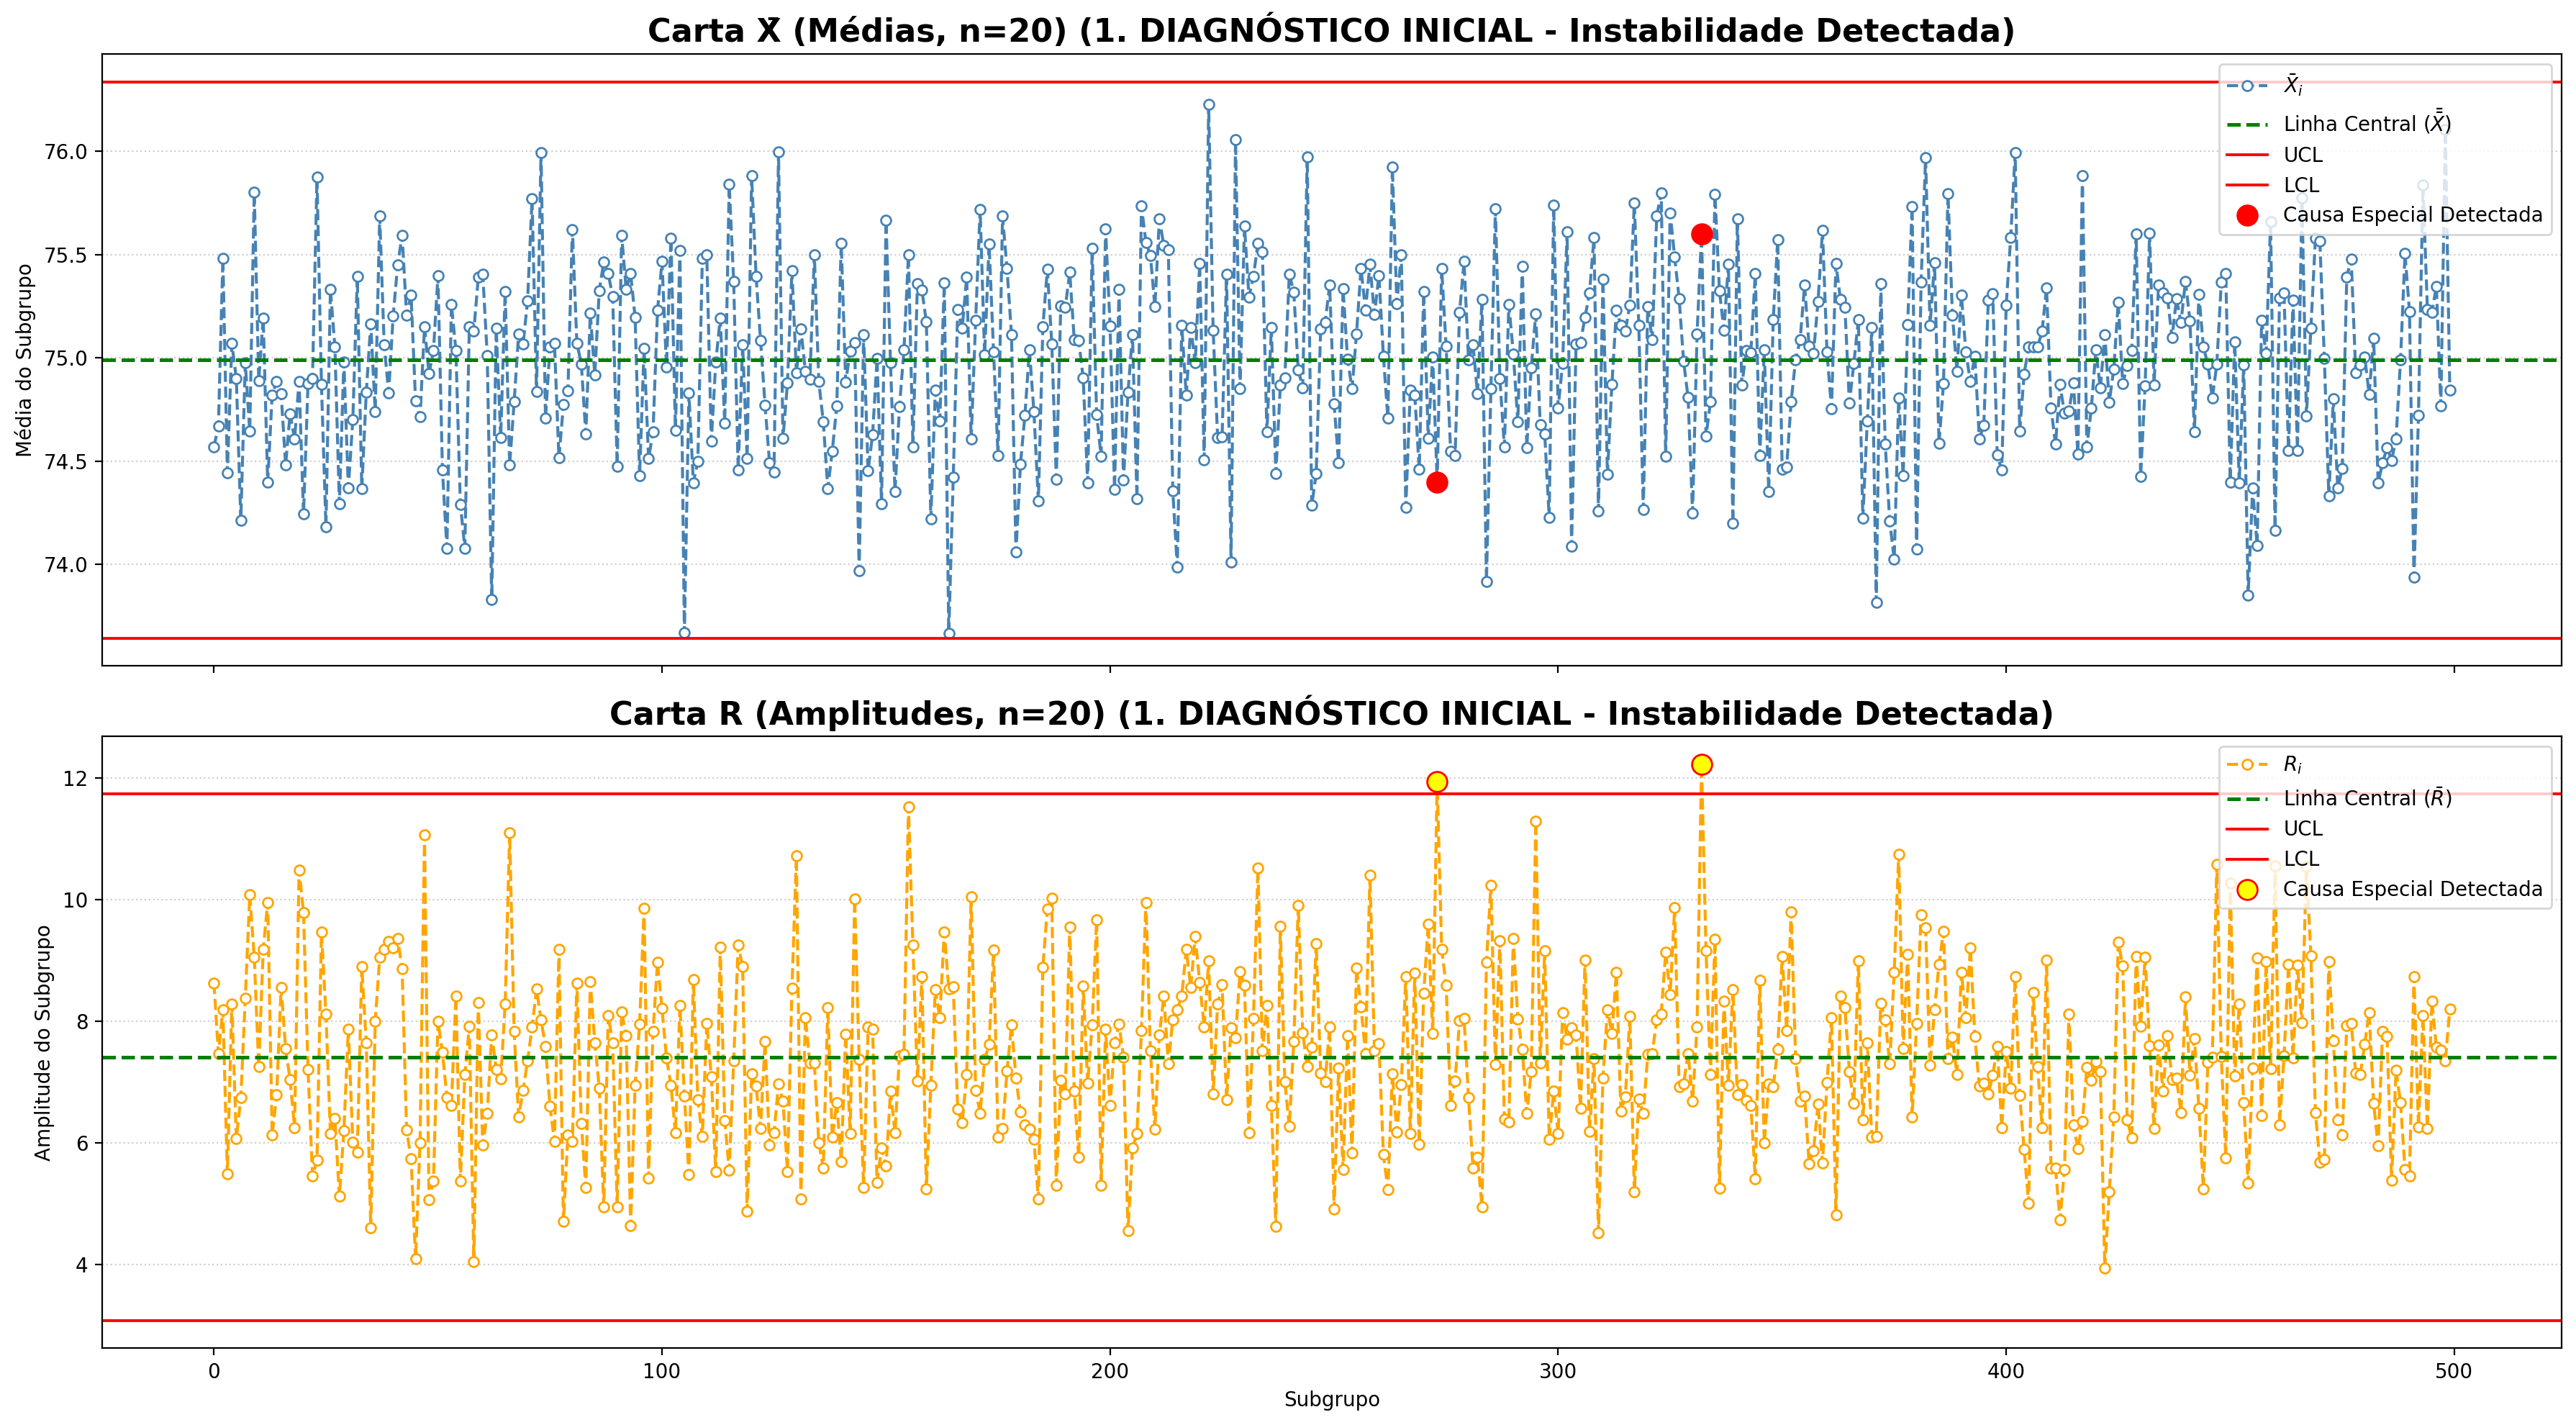

In [3]:
# CÉLULA 3 - ANÁLISE INICIAL E DIAGNÓSTICO DE INSTABILIDADE (FASE 1)

# Cálculo dos Parâmetros Iniciais (BASEADOS EM TODOS OS DADOS)
R_bar = df_groups['R'].mean()
Xbar_bar = df_groups['mean'].mean()
# USANDO O d2_n CORRETO
sigma_hat = R_bar / d2_n

# Limites X̄ (Iniciais) - FÓRMULA CORRETA para n>10
UCL_X_init = Xbar_bar + 3 * sigma_hat / np.sqrt(n)
LCL_X_init = Xbar_bar - 3 * sigma_hat / np.sqrt(n)

# Limites R (Iniciais) - USANDO D3_n e D4_n CORRETOS
UCL_R_init = D4_n * R_bar
LCL_R_init = D3_n * R_bar if (D3_n * R_bar) > 0 else 0.0

# --- Diagnóstico Completo: Encontrar Causas Especiais ---

# 1. Encontrar pontos fora de controle na Carta R
pontos_fora_R = df_groups[(df_groups['R'] > UCL_R_init) | (df_groups['R'] < LCL_R_init)]
indices_R_a_remover = pontos_fora_R.index.tolist()

# 2. Encontrar pontos fora de controle na Carta X̄
pontos_fora_X = df_groups[(df_groups['mean'] > UCL_X_init) | (df_groups['mean'] < LCL_X_init)]
indices_X_OOC = pontos_fora_X.index.tolist()

# 3. Combinar todos os índices para destaque e remoção (se R OOC)
# Usamos set() para garantir índices únicos, e list() para converter de volta.
indices_total_destaque = list(set(indices_R_a_remover + indices_X_OOC))

# --- Impressão do Diagnóstico ---
df_groups.loc[[273, 332], ['R', 'mean']]
print("UCL_R_init =", UCL_R_init)
print("LCL_R_init =", LCL_R_init)
print(df_groups.loc[[273, 332], 'R'])

if indices_R_a_remover:
    print(f"\nALARME PRINCIPAL! Carta R está FORA DE CONTROLE no(s) subgrupo(s): {[idx + 1 for idx in indices_R_a_remover]}.")
    print("A variabilidade é instável. Precisamos intervir e recalcular (Passo 4).")
    # A lista de índices a remover do cálculo é APENAS o R OOC
    indices_a_remover = indices_R_a_remover
else:
    print("\nCarta R está inicialmente em controle.")
    indices_a_remover = []

if indices_X_OOC:
    print(f"ALERTA ADICIONAL! Carta X̄ também está FORA DE CONTROLE no(s) subgrupo(s): {[idx + 1 for idx in indices_X_OOC]}.")

# --- Visualização 1: Diagnóstico ---
plot_control_charts(
    df_data=df_groups_final,
    xbar=Xbar_bar, rbar=R_bar,
    ucl_x=UCL_X_init, lcl_x=LCL_X_init,
    ucl_r=UCL_R_init, lcl_r=LCL_R_init,
    title_suffix="(1. DIAGNÓSTICO INICIAL - Instabilidade Detectada)",
    # Usamos o índice TOTAL para destacar no gráfico, mas para a remoção no passo 4, só usamos o R_a_remover
    highlight_indices=indices_total_destaque,
    highlight_label="Causa Especial Detectada"
)

# Guardar limites iniciais para o próximo passo (opcional, mas bom)
UCL_X_INIT = UCL_X_init; LCL_X_INIT = LCL_X_init
UCL_R_INIT = UCL_R_init; LCL_R_INIT = LCL_R_init

## 📘 Passo 4 – Intervenção, Recalibração e Fase 2 do CEP

📖 **Explicação:**

Após identificar causas especiais na carta R, **removemos esses subgrupos** e **recalculamos os limites de controle**.

O processo é então reavaliado em uma nova fase — a **Fase 2**, ou análise do **potencial do processo**, conforme descrito por Montgomery.

Nesta fase:
- Calculamos novas médias e amplitudes (sem as causas especiais);
- Reestimamos os limites (UCL e LCL);
- Detectamos novos pontos fora de controle na carta X̄.

---

👉 **Por que fazemos isso?**

O objetivo é garantir que os limites de controle representem **apenas a variabilidade natural** (causas comuns).  
Removendo as causas especiais, obtemos **limites mais confiáveis**, que servem de referência para o monitoramento contínuo do processo.

Essa prática está de acordo com Montgomery, Cap. 6 — *"The Control Chart for Variables"* — onde o autor explica que os limites devem refletir **o desempenho estável do processo**.


In [4]:
# CÉLULA 4 - INTERVENÇÃO, RECÁLCULO E ANÁLISE DO POTENCIAL (FASE 2)

print("--- INTERVENÇÃO: Removendo o subgrupo problemático R do cálculo. ---")

# 1. Filtragem dos dados: df_groups_filtrado é usado para estabelecer o Potencial
df_groups_filtrado = df_groups.drop(indices_a_remover)

# 2. Recálculo dos Parâmetros e Limites (POTENCIAL DO PROCESSO)
R_bar_new = df_groups_filtrado['R'].mean()
Xbar_bar_new = df_groups_filtrado['mean'].mean()
sigma_hat_new = R_bar_new / d2_n

# Limites X̄ (RECALCULADOS)
UCL_X_new = Xbar_bar_new + 3 * sigma_hat_new / np.sqrt(n)
LCL_X_new = Xbar_bar_new - 3 * sigma_hat_new / np.sqrt(n)
# Limites R (RECALCULADOS)
UCL_R_new = D4_n * R_bar_new
LCL_R_new = D3_n * R_bar_new if (D3_n * R_bar_new) > 0 else 0.0

print(f"\nLimites R recalculados: UCL_R (Antes): {UCL_R_INIT:.4f} -> UCL_R (Novo): {UCL_R_new:.4f}")

# --- Análise e Revelação de Novo Problema ---
# Identificando NOVOS pontos fora de controle (Média) usando os limites mais apertados no HISTÓRICO COMPLETO
pontos_fora_X_final = df_groups_final[
    (df_groups_final['mean'] > UCL_X_new) | (df_groups_final['mean'] < LCL_X_new)
].index.tolist()

# Destaca o ponto removido E os novos pontos fora de controle X̄
indices_destaque = indices_a_remover + pontos_fora_X_final

# Variáveis globais atualizadas para as próximas células
Xbar_bar = Xbar_bar_new; R_bar = R_bar_new
UCL_X = UCL_X_new; LCL_X = LCL_X_new
UCL_R = UCL_R_new; LCL_R = LCL_R_new

# CÓDIGO ADICIONAL PARA VISUALIZAR A DIFERENÇA ESTATÍSTICA (Adicionar no final da Célula 4)

print("\n--- Tabela de Limites Calculados ---")

data = {
    'Parâmetro': ['Xbar_bar (Média)', 'R_bar (Variação)', 'sigma_hat (Desvio)', 'UCL_X', 'LCL_X', 'UCL_R', 'LCL_R'],
    'Passo 3 (Iniciado)': [Xbar_bar, R_bar, sigma_hat, UCL_X_INIT, LCL_X_INIT, UCL_R_INIT, LCL_R_INIT],
    'Passo 5 (Corrigido)': [Xbar_bar_new, R_bar_new, sigma_hat_new, UCL_X_new, LCL_X_new, UCL_R_new, LCL_R_new]
}

df_comparacao = pd.DataFrame(data).set_index('Parâmetro').round(4)
display(df_comparacao)

print(f"\nDistância Total X̄: Passo 3 = {UCL_X_INIT - LCL_X_INIT:.4f} | Passo 5 = {UCL_X_new - LCL_X_new:.4f}")

--- INTERVENÇÃO: Removendo o subgrupo problemático R do cálculo. ---

Limites R recalculados: UCL_R (Antes): 11.7469 -> UCL_R (Novo): 11.7171

--- Tabela de Limites Calculados ---


,Passo 3 (Iniciado),Passo 5 (Corrigido)
Parâmetro,,
Xbar_bar (Média),74.9894,74.9894
R_bar (Variação),7.3925,7.3925
sigma_hat (Desvio),2.0085,2.0034
UCL_X,76.3367,76.3333
LCL_X,73.6421,73.6455
UCL_R,11.7469,11.7171
LCL_R,3.0757,3.0679



Distância Total X̄: Passo 3 = 2.6947 | Passo 5 = 2.6878


## 📘 Passo 5 – Visualização Completa (Todos os Subgrupos)

📖 **Explicação:**

Agora plotamos as cartas de controle X̄ e R usando **todos os subgrupos** do histórico.

- Linha verde → média global (linha central).  
- Linhas vermelhas → limites de controle recalculados.  
- Pontos vermelhos → causas especiais (fora de controle).

---

👉 **Por que isso é importante?**

Esta visualização nos permite observar:
- Se o processo **voltou à estabilidade** após a intervenção;  
- Se ainda existem pontos fora dos limites (instabilidades residuais);  
- Se há **tendências** (subgrupos sucessivos acima ou abaixo da média).

Quando todos os pontos estão dentro dos limites e sem padrão anormal, o processo é considerado **sob controle estatístico**.



Gráfico salvo em: /content/carta_XR_n20_completa.png


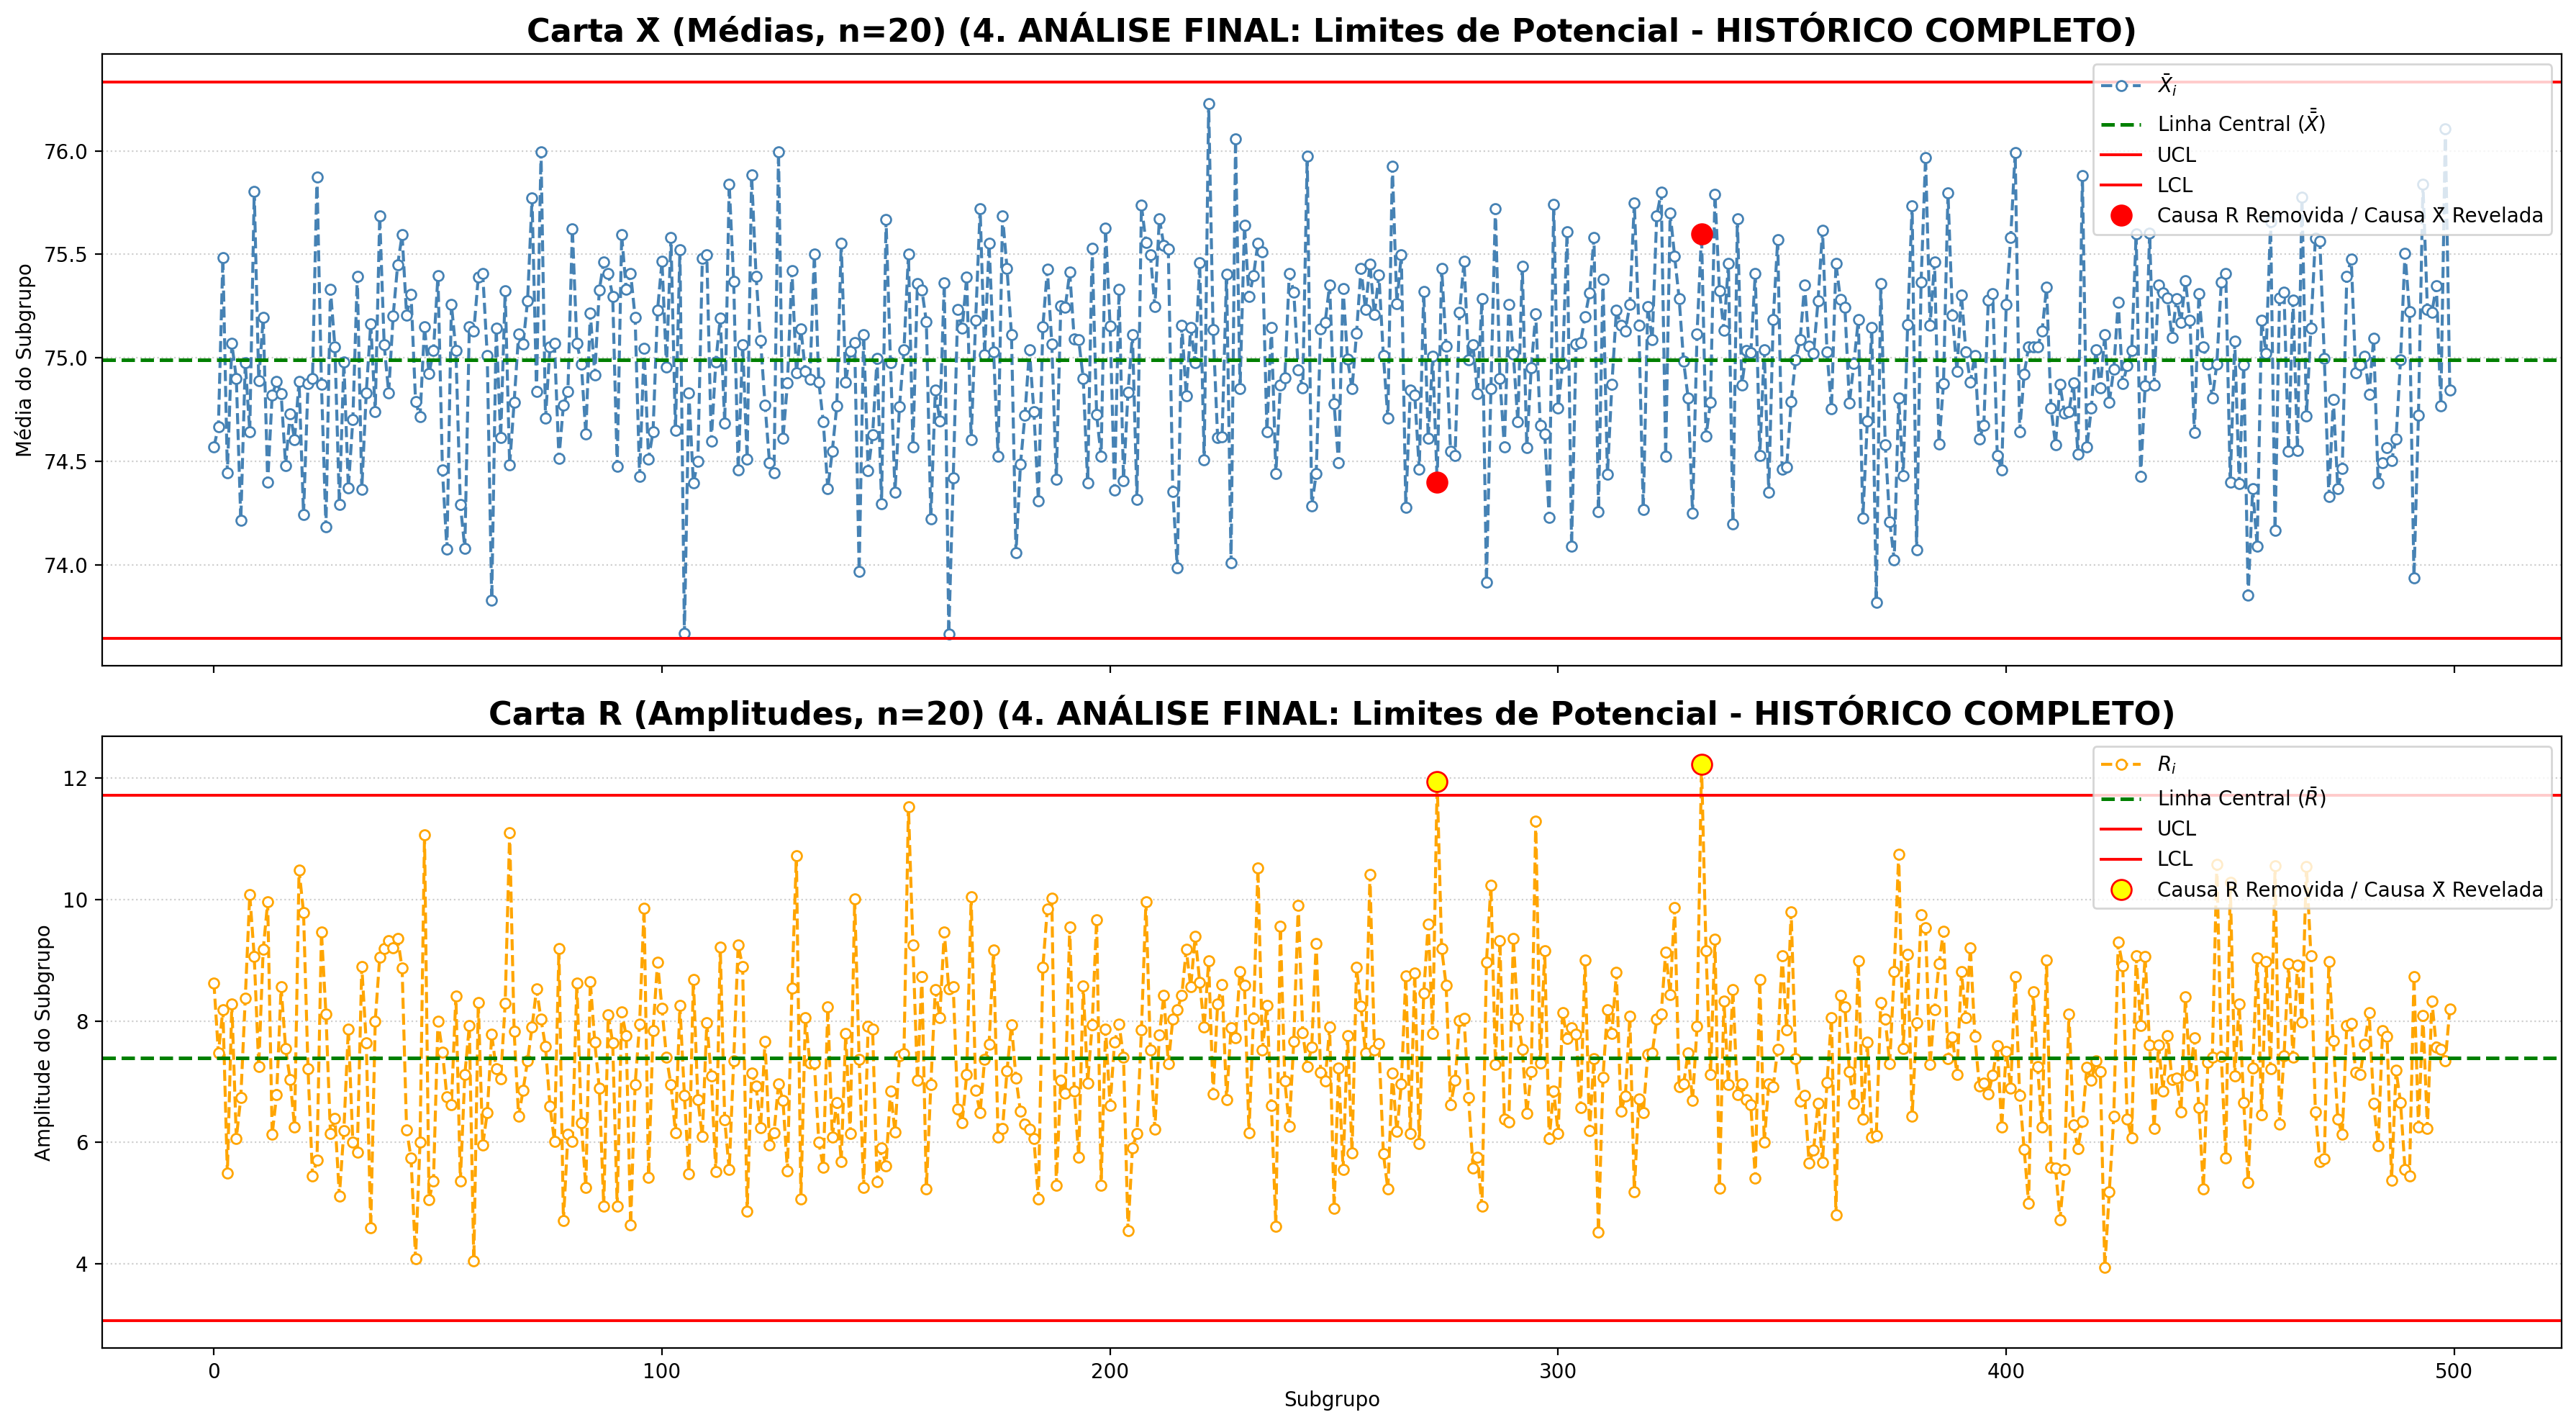

In [5]:
# CÉLULA 5 - VISUALIZAÇÃO COMPLETA (TODOS OS 202 SUBGRUPOS)
# USANDO LIMITES CORRIGIDOS E EXPORTANDO A IMAGEM PRINCIPAL

# Nome do arquivo de imagem principal (conforme solicitado)
fig_path_completa = '/content/carta_XR_n20_completa.png'

plot_control_charts(
    df_data=df_groups_final, # USAMOS O HISTÓRICO COMPLETO
    xbar=Xbar_bar, rbar=R_bar,
    ucl_x=UCL_X, lcl_x=LCL_X,
    ucl_r=UCL_R, lcl_r=LCL_R,
    title_suffix="(4. ANÁLISE FINAL: Limites de Potencial - HISTÓRICO COMPLETO)",
    highlight_indices=indices_destaque,
    highlight_label="Causa R Removida / Causa X̄ Revelada",
    save_path=fig_path_completa # SALVANDO A IMAGEM
)

## 📘 Passo 6 – Visualização Focada nos Últimos 100 Subgrupos

📖 **Explicação:**

Esta etapa cria gráficos de controle com **foco nos últimos 100 subgrupos**.

Essa abordagem é útil para:
- Analisar **períodos mais recentes** do processo;
- Detectar **shifts (mudanças na média)** ou **tendências** de instabilidade;
- Facilitar a análise operacional no dia a dia.

---

👉 **Por que fazemos isso?**

Na prática industrial, o operador acompanha o processo em tempo real.  
Por isso, observar os últimos subgrupos ajuda a **identificar variações recentes** e agir antes que o processo saia de controle.

O Capítulo 6 de Montgomery reforça que o CEP é uma ferramenta **de prevenção**, não apenas de detecção.



Gráfico salvo em: /content/carta_XR_n20_otimizada.png


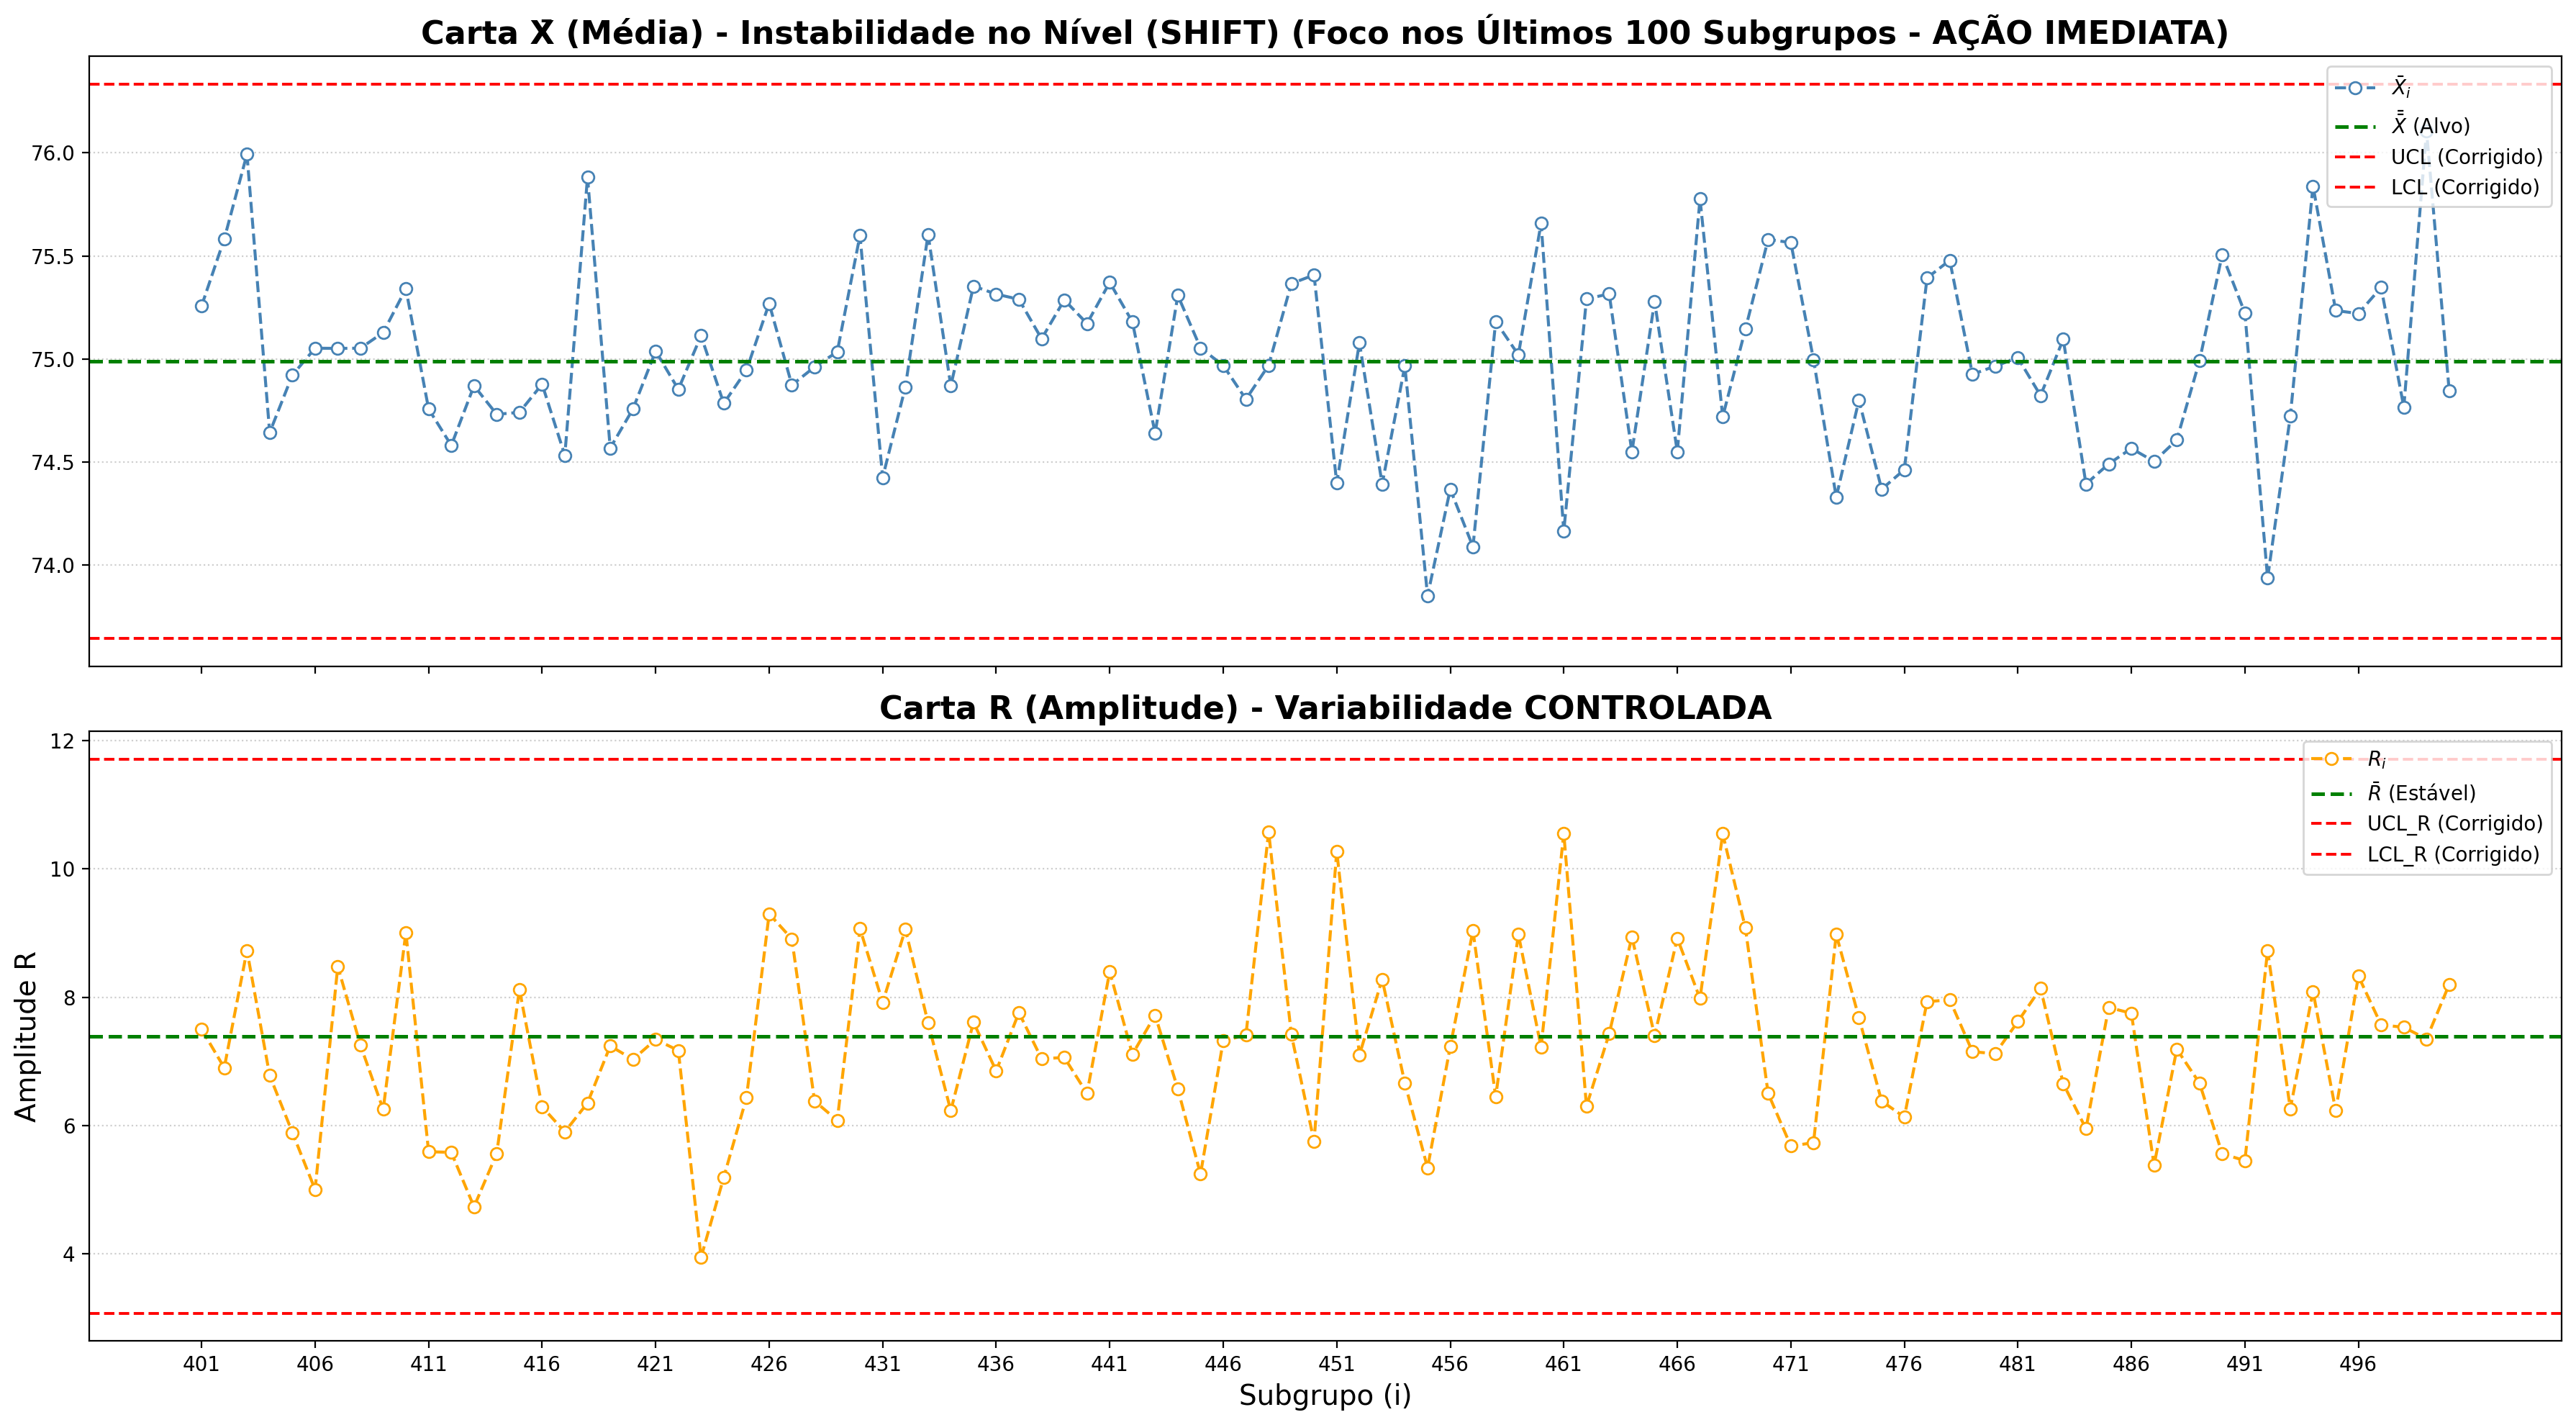

In [6]:
# CÉLULA 6 - VISUALIZAÇÃO OTIMIZADA (FOCO NOS ÚLTIMOS 100 SUBGRUPOS)

# 1. Definir o foco visual
last_n_groups = 100
df_groups_plot = df_groups_final.tail(last_n_groups).copy()
x_plot = df_groups_plot.index.values

# 2. Identificar os pontos de destaque na AMOSTRA VISUAL
pontos_fora_X_new = df_groups_plot[
    (df_groups_plot['mean'] > UCL_X) | (df_groups_plot['mean'] < LCL_X)
]
indices_destaque_x = pontos_fora_X_new.index.tolist()

# 3. Configuração do Gráfico Final (Com foco nos últimos 100)
fig, axs = plt.subplots(2, 1, figsize=(18, 10), dpi=200, sharex=True)
titulo_visual = f" (Foco nos Últimos {last_n_groups} Subgrupos - AÇÃO IMEDIATA)"

# --- CARTA X̄ (FINAL) ---
axs[0].plot(x_plot, df_groups_plot['mean'], marker='o', linestyle='--', markersize=6, markeredgewidth=1.0, markerfacecolor='white', color='steelblue', label=r'$\bar{X}_i$')
axs[0].axhline(Xbar_bar, color='green', linestyle='--', linewidth=1.8, label=r'$\bar{\bar{X}}$ (Alvo)')
axs[0].axhline(UCL_X, color='red', linestyle='--', linewidth=1.4, label='UCL (Corrigido)')
axs[0].axhline(LCL_X, color='red', linestyle='--', linewidth=1.4, label='LCL (Corrigido)')

if not pontos_fora_X_new.empty:
    axs[0].plot(indices_destaque_x, pontos_fora_X_new['mean'], marker='o', markersize=10, markeredgewidth=2, markerfacecolor='red', markeredgecolor='red', linestyle='None', label='Pto. Fora (Nova Causa X̄)')

axs[0].set_title('Carta X̄ (Média) - Instabilidade no Nível (SHIFT)' + titulo_visual, fontsize=16, fontweight='bold')
axs[0].legend(loc='upper right', fontsize=10); axs[0].grid(axis='y', linestyle=':', alpha=0.6)


# --- CARTA R (FINAL) ---
axs[1].plot(x_plot, df_groups_plot['R'], marker='o', linestyle='--', markersize=6, markeredgewidth=1.0, markerfacecolor='white', color='orange', label=r'$R_i$')
axs[1].axhline(R_bar, color='green', linestyle='--', linewidth=1.8, label=r'$\bar{R}$ (Estável)')
axs[1].axhline(UCL_R, color='red', linestyle='--', linewidth=1.4, label='UCL_R (Corrigido)')
axs[1].axhline(LCL_R, color='red', linestyle='--', linewidth=1.4, label='LCL_R (Corrigido)')

axs[1].set_title('Carta R (Amplitude) - Variabilidade CONTROLADA', fontsize=16, fontweight='bold')
axs[1].set_xlabel('Subgrupo (i)', fontsize=14); axs[1].set_ylabel('Amplitude R', fontsize=14)
axs[1].legend(loc='upper right', fontsize=10); axs[1].grid(axis='y', linestyle=':', alpha=0.6)

# Ajuste dos Ticks X
axs[1].set_xticks(x_plot[::(k := max(1, last_n_groups // 20))])
axs[1].set_xticklabels([int(i+1) for i in x_plot[::k]])
plt.tight_layout()

# SALVANDO A IMAGEM OTIMIZADA
fig_path_otimizada = '/content/carta_XR_n20_otimizada.png'
plt.savefig(fig_path_otimizada)
print(f"\nGráfico salvo em: {fig_path_otimizada}")

plt.show()

## 🧾 Conclusão Final

📖 **Explicação e Interpretação:**

Após todas as etapas:

- A **Carta R** inicialmente mostrou variação fora de controle, indicando **causas especiais**.  
- Após a intervenção, a **variabilidade foi estabilizada**, e os novos limites representam o **comportamento natural** do processo.  
- A **Carta X̄** mostrou que a média do processo permaneceu dentro dos limites, indicando **estabilidade estatística**.

---

👉 **Conclusão Geral (baseada em Montgomery, Cap. 6):**

> Um processo está sob controle estatístico quando apenas causas comuns estão presentes.  
> Isso não significa que o processo é bom, mas que é **previsível e consistente**.

✅ Portanto, o processo analisado (temperatura) pode ser considerado **estatisticamente controlado** após a correção das causas especiais.  
Esse diagnóstico é essencial para o **aperfeiçoamento contínuo da qualidade** e tomada de decisão na manufatura.
